In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 93% 307M/330M [00:01<00:00, 216MB/s]
100% 330M/330M [00:01<00:00, 213MB/s]


In [ ]:
import io
import os
import zipfile
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
file_dataset = 'face-mask-12k-images-dataset.zip'

with zipfile.ZipFile(file_dataset, 'r') as file_zip :
    file_zip.extractall()

In [ ]:
dataset_dir = '/content/Face Mask Dataset'

In [ ]:
masker_dir = os.path.join(dataset_dir, '/content/Face Mask Dataset/Train/WithMask')
tanpa_masker_dir = os.path.join(dataset_dir, '/content/Face Mask Dataset/Train/WithoutMask')

In [ ]:
masker = [os.path.join(masker_dir, img) for img in os.listdir(masker_dir) if img.endswith('.png')]
tanpa_masker = [os.path.join(tanpa_masker_dir, img) for img in os.listdir(tanpa_masker_dir) if img.endswith('.png')]

In [ ]:
label_masker  = [1] * len(masker)
label_tanpa_masker = [0] * len(tanpa_masker)

In [ ]:
gambar = masker + tanpa_masker
label  = label_masker + label_tanpa_masker

In [ ]:
df = pd.DataFrame({
    'Image': gambar,
    'Label': label
})

In [ ]:
df

,Image,Label
0,/content/Face Mask Dataset/Train/WithMask/Augm...,1
1,/content/Face Mask Dataset/Train/WithMask/Augm...,1
2,/content/Face Mask Dataset/Train/WithMask/Augm...,1
3,/content/Face Mask Dataset/Train/WithMask/934.png,1
4,/content/Face Mask Dataset/Train/WithMask/Augm...,1
...,...,...
9995,/content/Face Mask Dataset/Train/WithoutMask/5...,0
9996,/content/Face Mask Dataset/Train/WithoutMask/5...,0
9997,/content/Face Mask Dataset/Train/WithoutMask/3...,0
9998,/content/Face Mask Dataset/Train/WithoutMask/5...,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   10000 non-null  object
 1   Label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


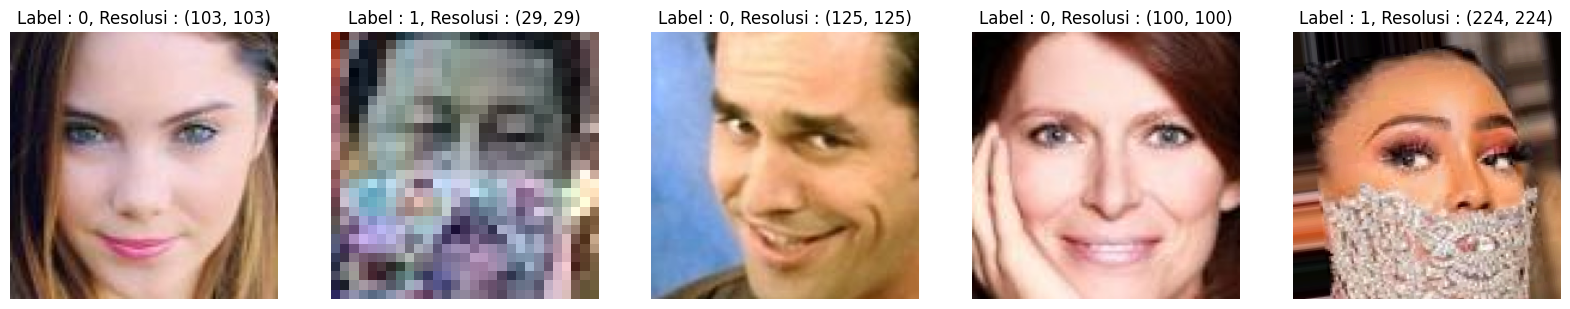

In [ ]:
sampel_gambar = df.sample(5)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for ax, (index, row) in zip(axes, sampel_gambar.iterrows()):
    gambar_dir = row['Image']
    label = row['Label']

    gambaran = Image.open(gambar_dir)

    ax.imshow(gambaran)
    ax.set_title(f"Label : {label}, Resolusi : {gambaran.size}")
    ax.axis('off')

plt.show()

In [ ]:
df['Label'] = df['Label'].astype(str)

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
print("Ukuran training set :", train_df.shape)
print("Ukuran test set :", test_df.shape)

Ukuran training set : (8000, 2)
Ukuran test set : (2000, 2)


In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='Image',
    y_col='Label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    subset=None
)
test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='Image',
    y_col='Label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    subset=None
)

Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_callback = ModelCheckpoint("model-image-classification-IDCAMP-2023.keras", save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(train_generator, epochs=5, validation_data=test_generator, callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/5
250/250 [==============================] - 34s 128ms/step - loss: 0.2546 - accuracy: 0.8946 - val_loss: 0.2110 - val_accuracy: 0.9260
Epoch 2/5
250/250 [==============================] - 27s 108ms/step - loss: 0.1712 - accuracy: 0.9376 - val_loss: 0.1604 - val_accuracy: 0.9375
Epoch 3/5
250/250 [==============================] - 26s 106ms/step - loss: 0.1557 - accuracy: 0.9446 - val_loss: 0.1814 - val_accuracy: 0.9335
Epoch 4/5
250/250 [==============================] - 27s 109ms/step - loss: 0.1454 - accuracy: 0.9460 - val_loss: 0.1287 - val_accuracy: 0.9530
Epoch 5/5
250/250 [==============================] - 27s 109ms/step - loss: 0.1202 - accuracy: 0.9584 - val_loss: 0.0951 - val_accuracy: 0.9705


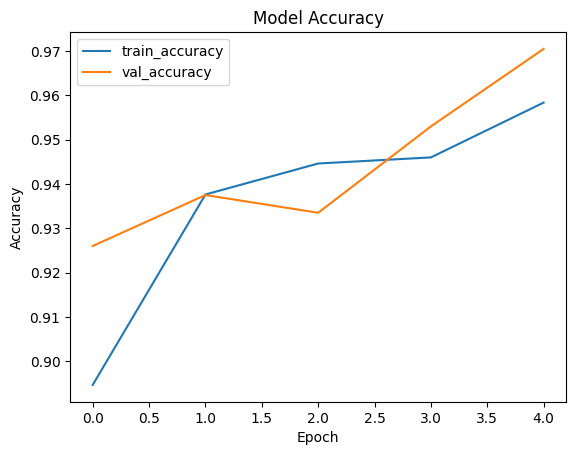

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

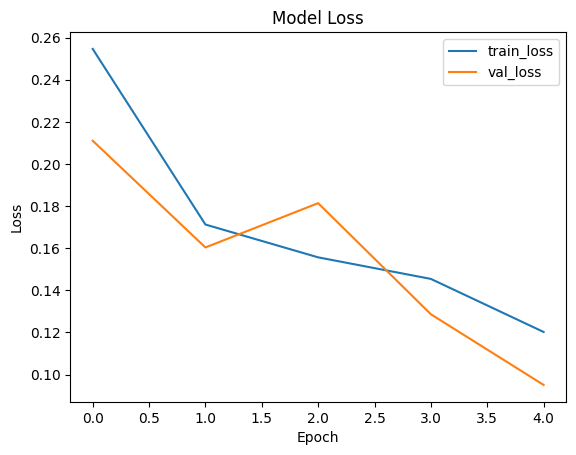

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model-image-classification-IDCAMP-2023.tflite', 'wb') as f:
    f.write(tflite_model)